TF Tutorial: https://www.tensorflow.org/tutorials/keras/regression

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [174]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


Read and organize data

In [175]:
sensors = ['98F4AB39DB50', '98F4AB38C884', '4C11AEE82D80']
columns = ['CO2', 'VOC', 'RH', 'TEM', 'PM25', 'TIME', 'SCORE']

sensor = 1
csv = f"../{sensors[0]}-processed.csv"

In [176]:
raw_dataset = pd.read_csv(csv)
dataset = raw_dataset.copy()
dataset = dataset.drop('TIME', axis=1)

In [177]:
dataset.isna().sum()
dataset = dataset.dropna()

In [178]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspect data

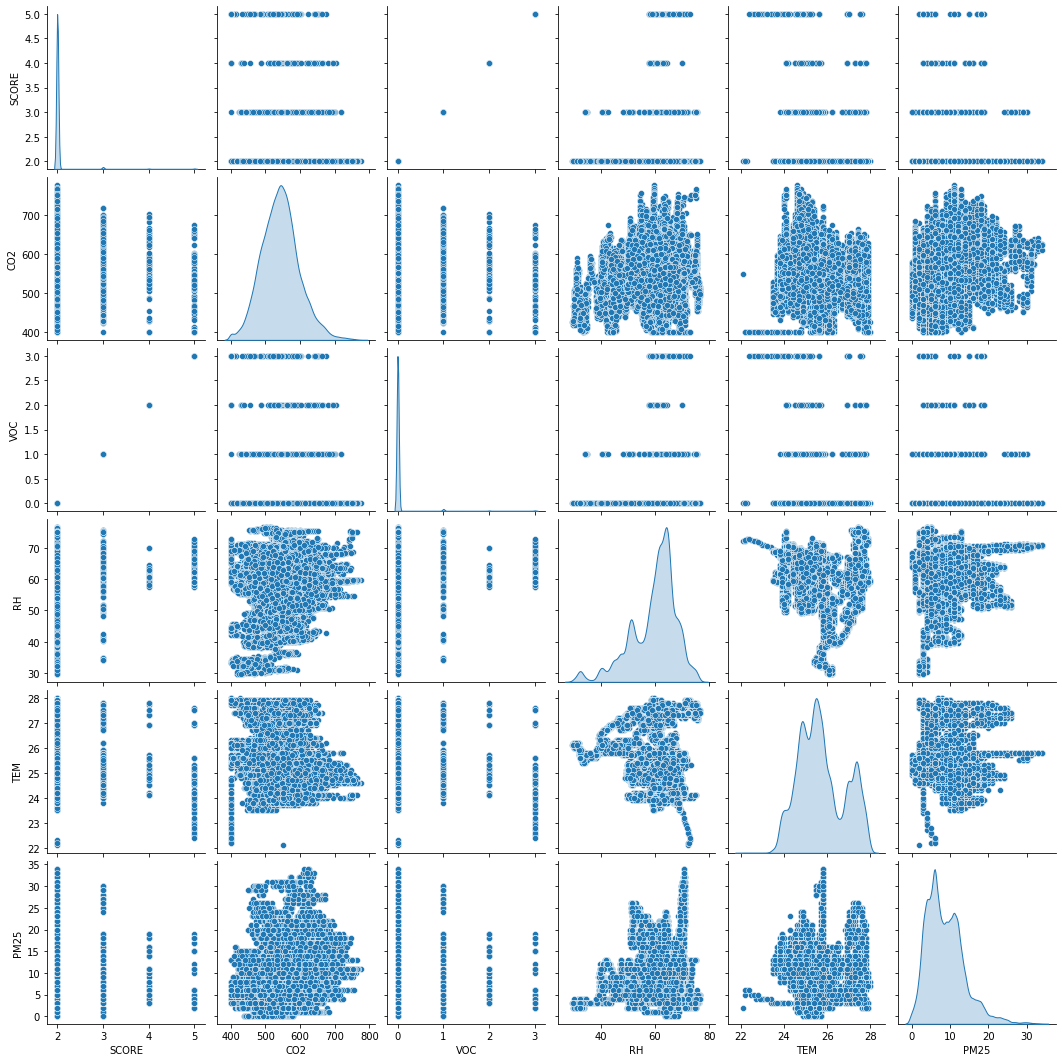

In [179]:
sns.pairplot(train_dataset[['SCORE', 'CO2', 'VOC', 'RH', 'TEM', 'PM25']], diag_kind='kde')


In [180]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO2,54602.0,542.596938,54.314313,400.0,506.0,541.0,575.0,777.0
VOC,54602.0,0.022856,0.198319,0.0,0.0,0.0,0.0,3.0
RH,54602.0,59.503729,8.360565,29.6,54.8,61.4,64.9,76.7
TEM,54602.0,25.728466,1.058173,22.1,24.9,25.6,26.6,28.0
PM25,54602.0,8.710798,4.924358,0.0,5.0,8.0,12.0,34.0
SCORE,54602.0,2.022856,0.198319,2.0,2.0,2.0,2.0,5.0


In [181]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('SCORE')
test_labels = test_features.pop('SCORE')

Normalization

In [182]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CO2,542.596938,54.314313
VOC,0.022856,0.198319
RH,59.503729,8.360565
TEM,25.728466,1.058173
PM25,8.710798,4.924358
SCORE,2.022856,0.198319


In [183]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[542.596   0.023  59.504  25.728   8.711]]


In [184]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[551.    0.   62.8  24.    9. ]]

Normalized: [[ 0.15 -0.12  0.39 -1.63  0.06]]


Linear regression with one variable

In [185]:
co2 = np.array(train_features['CO2'])

co2_normalizer = layers.Normalization(input_shape=[1,], axis=None)
co2_normalizer.adapt(co2)

In [186]:
co2_model = tf.keras.Sequential([
    co2_normalizer,
    layers.Dense(units=1)
])

co2_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [187]:
co2_model.predict(co2[:10])

array([[ 0.164],
       [ 0.047],
       [ 1.98 ],
       [ 2.742],
       [-0.929],
       [ 1.121],
       [ 1.863],
       [ 0.789],
       [ 2.234],
       [ 1.765]], dtype=float32)

In [188]:
co2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [189]:
%%time
history = co2_model.fit(
    train_features['CO2'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 2min 15s
Wall time: 1min 46s


In [190]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.037032,0.032166,95
96,0.036694,0.034723,96
97,0.035989,0.027617,97
98,0.036116,0.031139,98
99,0.035916,0.034690,99


In [191]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [SCORE]')
  plt.legend()
  plt.grid(True)

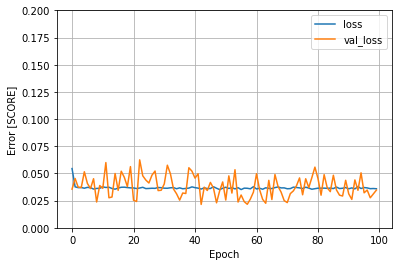

In [192]:
plot_loss(history)

In [193]:
test_results = {}

test_results['co2_model'] = co2_model.evaluate(
    test_features['CO2'],
    test_labels, verbose=0)

In [194]:
x = tf.linspace(0.0, 250, 251)
y = co2_model.predict(x)

In [195]:
def plot_co2(x, y):
  plt.scatter(train_features['CO2'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('CO2')
  plt.ylabel('SCORE')
  plt.legend()

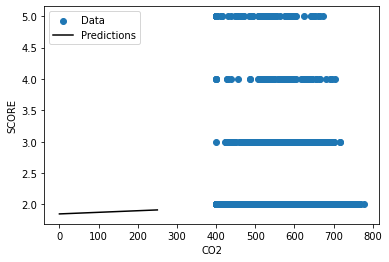

In [196]:
plot_co2(x, y)

Linear regression with multiple inputs

In [197]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [198]:
linear_model.predict(train_features[:10])

array([[-0.707],
       [-0.615],
       [ 0.634],
       [ 1.141],
       [-1.167],
       [ 0.592],
       [ 1.123],
       [ 0.02 ],
       [ 0.109],
       [ 0.859]], dtype=float32)

In [199]:
linear_model.layers[1].kernel

<tf.Variable 'dense_24/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.717],
       [ 0.646],
       [ 0.293],
       [ 0.51 ],
       [-0.447]], dtype=float32)>

In [200]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [201]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 2min 17s
Wall time: 1min 47s


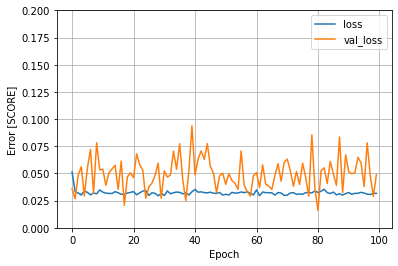

In [202]:
plot_loss(history)

In [203]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

Regression with a deep neural network (DNN)

In [204]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Regression using a DNN and a single input

In [205]:
dnn_co2_model = build_and_compile_model(co2_normalizer)
dnn_co2_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_25 (Dense)            (None, 64)                128       
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [206]:
%%time
history = dnn_co2_model.fit(
    train_features['CO2'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 3min 54s
Wall time: 2min 15s


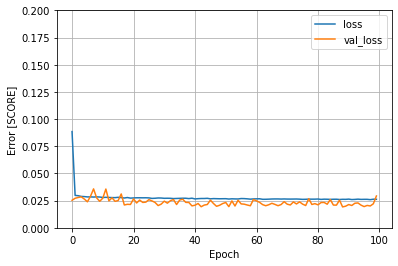

In [207]:
plot_loss(history)

In [208]:
x = tf.linspace(0.0, 250, 251)
y = dnn_co2_model.predict(x)

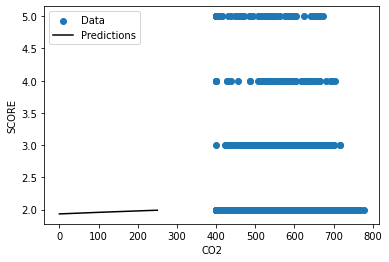

In [209]:
plot_co2(x, y)

In [210]:
test_results['dnn_co2_model'] = dnn_co2_model.evaluate(
    test_features['CO2'], test_labels,
    verbose=0)

Regression using a DNN and multiple inputs

In [211]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 64)                384       
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [212]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 4min 18s
Wall time: 2min 21s


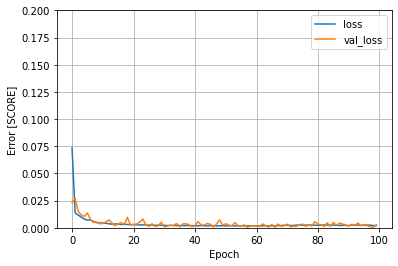

In [213]:
plot_loss(history)

In [214]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Performance

In [215]:
pd.DataFrame(test_results, index=['Mean absolute error [SCORE]']).T

,Mean absolute error [SCORE]
co2_model,0.043103
linear_model,0.050302
dnn_co2_model,0.037658
dnn_model,0.002780


Predictions

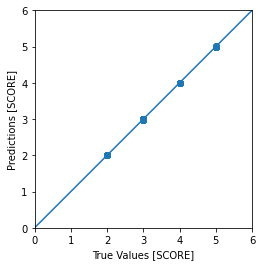

In [216]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SCORE]')
plt.ylabel('Predictions [SCORE]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

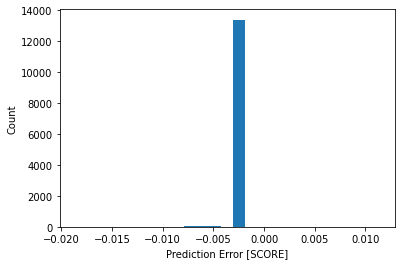

In [217]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SCORE]')
_ = plt.ylabel('Count')

In [218]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


*** RELOAD MODEL

In [219]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [220]:
pd.DataFrame(test_results, index=['Mean absolute error [SCORE]']).T

,Mean absolute error [SCORE]
co2_model,0.043103
linear_model,0.050302
dnn_co2_model,0.037658
dnn_model,0.002780
reloaded,0.002780
